In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5462393.datarmor0/parcels-502090/libparcels_random_227db283-c592-4bb8-b256-ce60d1f9032e.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)
#
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.148.0.221:60776' processes=21 threads=21, memory=335.37 GiB>

In [4]:
def binned_spectra_site(bbox,df,dl):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df_sub[np.logical_and(df_sub.lon<bbox[1],df_sub.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lat_cut']).mean().compute()
    _ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
                                  ).drop(columns=['time','lon','lat']
                                        ).reset_index(),id_vars=['lat_cut'],var_name='frequency')

    _ds['frequency'] = _ds['frequency'].astype('float64')
    ds_sub = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
                   ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    return ds_sub

In [126]:
def binned_Espectra_site(bbox,ds,dl):
    ds['lat'] = 0*ds_E.face+ds.YC
    ds['lon'] = 0*ds_E.face+ds.XC
    ds['lat4'] = 0*ds_E.SSUV+ds.YC
    ds = ds.persist()
    ds_sub = ds.where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_sub = ds_sub.where(np.logical_and(ds_sub.lon<=bbox[1],ds_sub.lon>=bbox[0]),drop=True).persist()
    lat = np.arange(bbox[-2], bbox[-1], dl)
    ds_sub = ds_sub.compute()
    ds_sub = ds_sub.drop(['face','XC','YC','Depth']).isel(face=0).to_dataframe()
    ds_sub['lat_cut'] = pd.cut(ds_sub['lat'], lat)
    df_mean = ds_sub.groupby(['lat_cut','freq_time']).mean().reset_index()
    df_mean['lat_cut'] = df_mean.lat_cut.map(lambda r:r.mid)#set_index(df_mean.index.map(lambda v: v.mid))
    ds_mean = df_mean.reset_index().rename(columns={'lat_cut':'lat_bins','freq_time':'frequency'}
                                          ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
#    N = histogram(ds_sub.lat, bins=[lat], 
#              dim=['i', 'j', 'face']
#            ).persist()
#    E = histogram(ds_sub.lat4.rename('lat'), bins=[lat], 
#             weights=ds_sub.SSUV, 
#              dim=['i', 'j', 'face']
#             )

#    E = (E/N).rename('E_SSUV').persist()
#    E = E.rename({'freq_time': 'frequency','lat_bin':'lat_bins'})
    return ds_mean

In [4]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])

In [5]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_raw_uv_mean0').persist()
df_Lspectra_mean1 = p.load_diagnostic('spectra_raw_uv_mean1').persist()
df_Lspectra_mean2 = p.load_diagnostic('spectra_raw_uv_mean2').persist()

In [6]:
import os
sub = 2
ds_E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60.zarr'))
ds_E = ds_E.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E = ds_E.where(ds_E.Depth>500, drop=False)
print(ds_E)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 540, j: 540)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
  * j          (j) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    mask       (face, j, i) bool dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 24, 36, 1440), meta=np.ndarray>


In [13]:
bbox = [-128, -120, 33, 38]
df = df_Lspectra_mean0
df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

df_sub = df_sub[np.logical_and(df_sub.lon<bbox[1],df_sub.lon>bbox[0]
                                          )].persist()

In [16]:
ds_E = ds_E.persist()
ds_sub = ds_E.where(np.logical_and(ds_E.lat<=bbox[3],ds_E.lat>=bbox[2]),drop=True).persist()
ds_sub = ds_sub.where(np.logical_and(ds_sub.lon<=bbox[1],ds_sub.lon>=bbox[0]),drop=True).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [17]:
ds_sub = ds_sub.compute()
df_sub = df_sub.compute()

In [19]:
ds_sub = ds_sub.isel(face=0)

In [37]:
np.unique(ds_sub.where(np.isnan(ds_sub.SSUV)==True,drop=True).lon.values.flatten()).size

466580

In [50]:

_ds = pd.melt(df_sub.drop(columns=['time','lon','lat']),var_name='frequency')

In [52]:
_ds = _ds.set_index('frequency')

In [65]:
df_sub.to_xarray()

<xarray.Dataset>
Dimensions:                (trajectory: 404)
Coordinates:
  * trajectory             (trajectory) int64 38001179 38001179 ... 38000986
Data variables: (12/1443)
    time                   (trajectory) int64 2880 3600 720 ... 2160 2880 4320
    lon                    (trajectory) float64 -125.0 -123.8 ... -124.7 -127.7
    lat                    (trajectory) float64 36.43 34.34 ... 33.29 36.77
    0.0                    (trajectory) float64 0.5755 0.5117 ... 0.721 1.316
    0.016666666666666666   (trajectory) float64 0.3457 0.1207 ... 0.4054 0.895
    0.03333333333333333    (trajectory) float64 0.02879 0.009231 ... 0.4064
    ...                     ...
    -0.1                   (trajectory) float64 0.01498 0.02924 ... 0.0424
    -0.08333333333333333   (trajectory) float64 0.03906 0.06548 ... 0.1162
    -0.06666666666666667   (trajectory) float64 0.02892 0.2207 ... 0.04558
    -0.05                  (trajectory) float64 0.03809 0.2209 ... 0.007745
    -0.03333333333333333   (trajectory) float64 0.05542 0.036 ... 0.01904
    -0.016666666666666666  (trajectory) float64 0.07042 0.5225 ... 0.1444 0.4818

In [62]:
df_lonlat = df_sub.iloc[:,:3]

In [64]:
df_lonlat.to_xarray().where(lon=ds_sub.where(np.isnan(ds_sub.SSUV)==True,drop=True).lon.values.flatten())

TypeError: where() got an unexpected keyword argument 'lon'

In [30]:
ds_sub.lon[np.isnan(ds_sub.SSUV.isel(freq_time=1000).values)]

IndexError: Unlabeled multi-dimensional array cannot be used for indexing: j

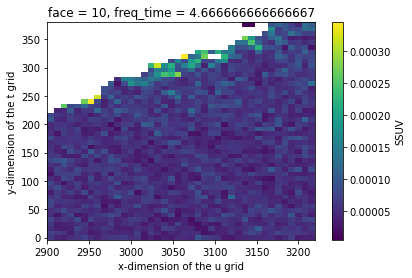

In [24]:
ds_sub.SSUV.isel(freq_time=1000).plot()

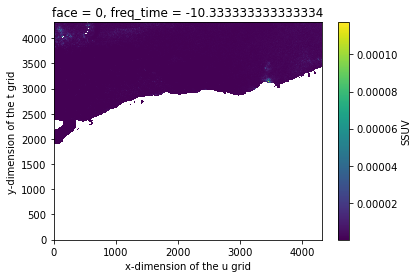

In [133]:
ds_E.isel(face=0,freq_time=100).mask.plot()

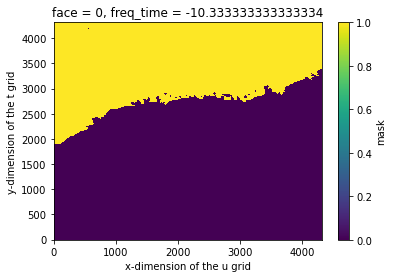

In [134]:
ds_E.isel(face=0,freq_time=100).mask.plot()

In [9]:
ds_E['lat'] = 0*ds_E.face+ds_E.YC
ds_E['lon'] = 0*ds_E.face+ds_E.XC


<xarray.Dataset>
Dimensions:    (i: 540, j: 540)
Coordinates:
    Depth      (j, i) float32 dask.array<chunksize=(540, 540), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(540, 540), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(540, 540), meta=np.ndarray>
    face       int64 0
    freq_time  float64 -10.33
  * i          (i) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
  * j          (j) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    mask       (j, i) bool dask.array<chunksize=(540, 540), meta=np.ndarray>
Data variables:
    SSUV       (j, i) float64 dask.array<chunksize=(24, 36), meta=np.ndarray>
    lat        (j, i) float64 dask.array<chunksize=(540, 540), meta=np.ndarray>
    lon        (j, i) float64 dask.array<chunksize=(540, 540), meta=np.ndarray>

In [10]:
ds_E.isel(face=0,freq_time=100).lon

<xarray.DataArray 'lon' (j: 540, i: 540)>
dask.array<getitem, shape=(540, 540), dtype=float64, chunksize=(540, 540), chunktype=numpy.ndarray>
Coordinates:
    Depth      (j, i) float32 dask.array<chunksize=(540, 540), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(540, 540), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(540, 540), meta=np.ndarray>
    face       int64 0
    freq_time  float64 -10.33
  * i          (i) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
  * j          (j) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    mask       (j, i) bool dask.array<chunksize=(540, 540), meta=np.ndarray>

### California

In [8]:
bbox = [-128, -120, 33, 38]

In [10]:
dl = 1.

In [11]:
df_mean0_Cal = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Cal = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Cal = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [12]:
ds_Cal = xr.merge([df_mean0_Cal,df_mean1_Cal.uv.rename('uv_mean1')
                   ,df_mean2_Cal.uv.rename('uv_mean2')])

In [120]:
dsE_Cal = binned_Espectra_site(bbox,ds_E,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.Dataset>
Dimensions:    (face: 1, freq_time: 1440, i: 40, j: 48)
Coordinates:
    Depth      (face, j, i) float32 4.675e+03 4.479e+03 ... 1.013e+03 556.8
    XC         (face, j, i) float32 -128.0 -128.0 -128.0 ... -120.2 -120.2
    YC         (face, j, i) float32 37.9 37.78 37.66 37.54 ... 33.28 33.15 33.02
  * face       (face) int64 10
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 2904 2912 2920 2928 2936 ... 3184 3192 3200 3208 3216
  * j          (j) int64 0 8 16 24 32 40 48 56 ... 328 336 344 352 360 368 376
    mask       (face, j, i) bool True True True True ... True True True True
Data variables:
    SSUV       (face, j, i, freq_time) float64 1.743e-05 2.477e-05 ... 5.197e-05
    lat        (face, j, i) float64 37.9 37.78 37.66 37.54 ... 33.28 33.15 33.02
    lon        (face, j, i) float64 -128.0 -128.0 -128.0 ... -120.2 -120.2
    lat4       (face, j, i, freq_time) float64 37.9 37.9 37.9 ... 33.02 33.02
     lat

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('xarray-SSUV-getitem-af42f83a7dae20d0298aec0781fd3d84', 7, 19, 7, 0)"


(-5.0, 5.0)

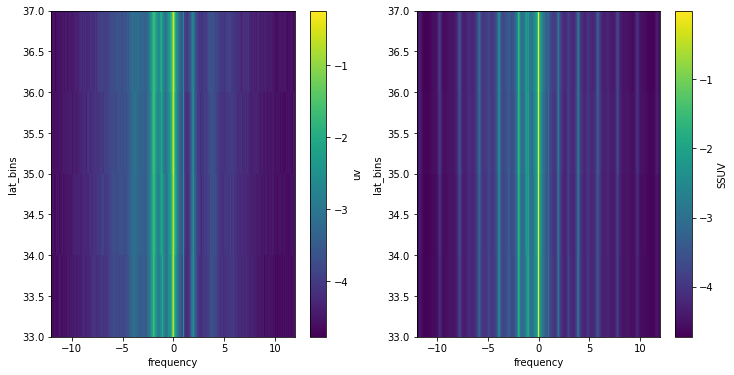

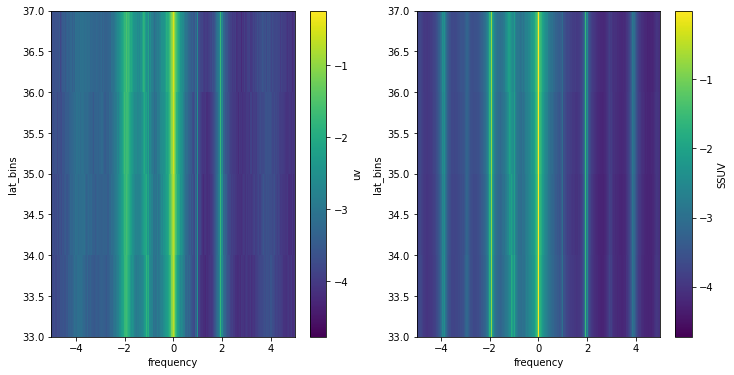

In [122]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
np.log10(ds_Cal['uv']).plot(ax=ax[0])
np.log10(dsE_Cal.SSUV).plot(ax=ax[1],y='lat_bins')
fig,ax = plt.subplots(1,2,figsize=(12,6))
np.log10(ds_Cal['uv']).plot(ax=ax[0])
np.log10(dsE_Cal.SSUV).plot(ax=ax[1],y='lat_bins')
ax[0].set_xlim(-5,5);ax[1].set_xlim(-5,5)

(-5.0, 5.0)

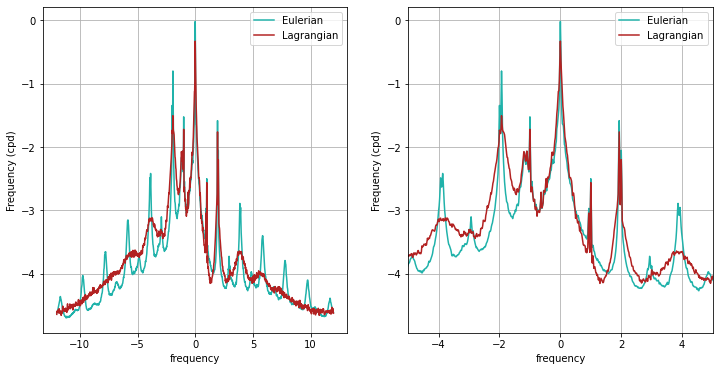

In [123]:
fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax in axs:
    np.log10(dsE_Cal.SSUV.mean('lat_bins')).plot(ax=ax,label='Eulerian',c='lightseagreen')
    np.log10(ds_Cal['uv'].mean('lat_bins')).plot(ax=ax,label='Lagrangian',c='firebrick')
    ax.grid();ax.legend();ax.set_ylabel('Frequency (cpd)')
axs[1].set_xlim(-5,5)

In [138]:
df_Lspectra_mean0.lon.compute()

TypeError: 'Future' object is not subscriptable

In [66]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
